# Bayesian Optimization

<div class="admonition goal">
    <p class="admonition-title">Goal</p>
    <p>
        This notebook aims to showcase how can you use Bayesian optimization with the `inspeqtor` library.
    </p>
</div>

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import inspeqtor as sq

sq.utils.enable_jax_x64()

Let us start by define the true function without noise, which we cannot directly interact, and the noisy function that we can collect the data from.

In [2]:
def true_fn(x):
    return jnp.sin(4 * x) + jnp.cos(2 * x)


def noisy_fn(key, x, noise=0.3):
    y = true_fn(x)

    return y + jax.random.normal(key, shape=y.shape) * noise

We now define how we want to interact with the system (`noisy_fn`). We have to interact with it through the `ControlSequence`. Remember that `ControlSequence` did not perform any fancy, magic stuff, we just simply handle the IO operation and how to sample the control parameter from it efficiently for you. Under the hood, the `get_envelope` function is a simple python function for you to define.

Below is a minimal implementation of `ControlSequence`. What matter for us in this tutorial is the ability to sample `x` from allowed interval, which is from -3.0 to 3.0 in this case. The `get_envelope` function will just return a zero vector.

In [3]:
from dataclasses import dataclass


@dataclass
class XControl(sq.control.BaseControl):
    total_dt: int = 10

    def get_bounds(
        self,
    ) -> tuple[sq.control.ParametersDictType, sq.control.ParametersDictType]:
        return {"x": -3.0}, {"x": 3.0}

    def get_envelope(self, params: sq.control.ParametersDictType):
        def envelope(t):
            return jnp.zeros_like(jnp.arange(self.total_dt))

        return envelope


total_dt = 10  # Does not matter in the example
ctrl_seq = sq.control.ControlSequence(
    controls={"x": XControl(total_dt)}, total_dt=total_dt
)

Now, we sample from the control and then collect some data (`n = 10`) from `noisy_fn`.

In [4]:
n = 10
key = jax.random.key(0)
key, x_key, y_key = jax.random.split(key, 3)
ravel_fn, _ = sq.control.ravel_unravel_fn(ctrl_seq)
x = jax.vmap(ravel_fn)(jax.vmap(ctrl_seq.sample_params)(jax.random.split(x_key, n)))
y = noisy_fn(y_key, x)

Next, we can now initialize our Bayesian optimizer and perform sequential experiment using the suggested candidates.

In [5]:
opt_state = sq.optimize.init_opt_state(x, y, ctrl_seq)

key = jax.random.key(0)
for step in range(10):
    key, sample_key, exp_key = jax.random.split(key, 3)

    x_candidate = sq.optimize.suggest_next_candidates(
        sample_key, opt_state, num_suggest=5, exploration_factor=2.0
    )
    # Evaluate at new candidate
    y_new = noisy_fn(exp_key, x_candidate)
    # Update the GP
    opt_state = sq.optimize.add_observations(opt_state, x=x_candidate, y=y_new)

Optimization terminated successfully.
         Current function value: 0.951876
         Iterations: 13
         Function evaluations: 17
         Gradient evaluations: 17
Optimization terminated successfully.
         Current function value: 6.887604
         Iterations: 9
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 7.769033
         Iterations: 10
         Function evaluations: 15
         Gradient evaluations: 15
Optimization terminated successfully.
         Current function value: 5.233201
         Iterations: 10
         Function evaluations: 14
         Gradient evaluations: 14
Optimization terminated successfully.
         Current function value: 12.274840
         Iterations: 12
         Function evaluations: 18
         Gradient evaluations: 18
Optimization terminated successfully.
         Current function value: 11.648742
         Iterations: 12
         Function evaluations: 19
 

Finally, let us plot the optimization result.

Optimization terminated successfully.
         Current function value: 18.529629
         Iterations: 11
         Function evaluations: 14
         Gradient evaluations: 14


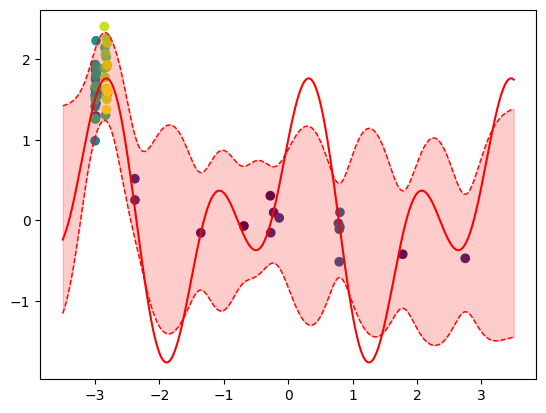

In [6]:
exp_x = opt_state.dataset.X
exp_y = opt_state.dataset.y

assert isinstance(exp_x, jnp.ndarray) and isinstance(exp_y, jnp.ndarray)

fig, ax = plt.subplots()
ax.scatter(exp_x, exp_y, label="Observations", c=jnp.arange(opt_state.dataset.n))

x_test = jnp.linspace(-3.5, 3.5, 500).reshape(-1, 1)
y_true = true_fn(x_test)
ax.plot(x_test, y_true, label="Latent function", color="red")

mean, variance = sq.optimize.predict_mean_and_std(x_test, opt_state.dataset)
ax.fill_between(
    x_test.squeeze(),
    mean - 2 * variance,
    mean + 2 * variance,
    alpha=0.2,
    label="Two sigma",
    color="red",
)
ax.plot(
    x_test,
    mean - 2 * variance,
    linestyle="--",
    linewidth=1,
    color="red",
)
ax.plot(
    x_test,
    mean + 2 * variance,
    linestyle="--",
    linewidth=1,
    color="red",
)